# Neural Network for racetime prediction

### Define a logger for logging experiments configurations and results

In [19]:
import json
import os
from datetime import datetime
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities.rank_zero import rank_zero_only

class F1NeuralNetworkExperimentsLogger(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = []
        self.logs = {}
        self._version = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    @property
    def name(self):
        return "F1NeuralNetworkExperimentsLogger"

    @property
    def version(self):
        return self._version
    
    @rank_zero_only
    def log_model_architecture(self, model):
        def layer_to_dict(layer):
            """Convert a PyTorch layer to a structured dictionary."""
            return {
                'type': layer.__class__.__name__,
                'parameters': {
                    name: p.shape if hasattr(p, 'shape') else str(p)
                    for name, p in layer.named_parameters(recurse=False)
                },
                'submodules': [layer_to_dict(sub) for sub in layer.children()]
            }

        architecture_dict = layer_to_dict(model)
        self.logs['model_architecture'] = architecture_dict


    @rank_zero_only
    def log_hyperparams(self, params):
        self.logs['hyperparameters'] = {k: str(v) for k, v in params.items()}

    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.metrics.append((step, metrics))
        if 'metrics' not in self.logs:
            self.logs['metrics'] = []
        self.logs['metrics'].append({'step': step, 'metrics': {k: float(v) for k, v in metrics.items()}})

    @rank_zero_only
    def log_overall_test_loss(self, test_loss):
        self.logs['overall_test_loss'] = test_loss

    @rank_zero_only
    def log_used_features(self, features):
        self.logs['used_features'] = features

    @rank_zero_only
    def log_optimization_strategy(self, optimizer, scheduler):
        optimizer_str = str(optimizer)
        scheduler_str = str(scheduler)
        self.logs['optimizer'] = optimizer_str
        self.logs['scheduler'] = scheduler_str

    @rank_zero_only
    def save(self):
        directory = os.path.join(self.name, self.version)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(os.path.join(directory, "logs.json"), "w") as f:
            json.dump(self.logs, f, indent=4)

    @rank_zero_only
    def finalize(self, status):
        self.save()

logger = F1NeuralNetworkExperimentsLogger()

### Preprocess and load the features and labels for regression

In [20]:
from data_preparation import load_and_preprocess_data, prepare_regression_data, split_data_by_race
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

class F1Dataset(Dataset):
    def __init__(self, X, y, scaler=None):
        super().__init__()
        self.X = X.reset_index(drop=True)
        print(self.X.columns)
        self.y = y.reset_index(drop=True)
        self.scaler = scaler
        if self.scaler:
            self.scaler.fit(self.X)
            self.X = pd.DataFrame(self.scaler.fit_transform(self.X), columns=self.X.columns)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)  # Access by iloc
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32)  # Access by iloc
        return X, y

train_df, test_df = split_data_by_race(load_and_preprocess_data())
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

X_train, y_train = prepare_regression_data(train_df)
X_val, y_val = prepare_regression_data(val_df)
X_test, y_test = prepare_regression_data(test_df)

N_FEATURES = X_train.shape[1]
print(f"Number of features: {N_FEATURES}")


scaler = StandardScaler()

train_dataset = F1Dataset(X_train, y_train, scaler=scaler)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = F1Dataset(X_val, y_val, scaler=scaler)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataset = F1Dataset(X_test, y_test, scaler=scaler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

train_dataset.__getitem__(0)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'racetime_milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')


/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:43: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  practice_sessions = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  tire_data = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:158: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Number of features: 19
Index(['driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
       'driver_reliability', 'driver_aggression', 'driver_risk_taking',
       'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time',
       'tire_age', 'fuel_load', 'track_position', 'TrackTemp', 'AirTemp',
       'Humidity', 'tire_compound', 'TrackStatus', 'is_pit_lap'],
      dtype='object')
Index(['driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
       'driver_reliability', 'driver_aggression', 'driver_risk_taking',
       'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time',
       'tire_age', 'fuel_load', 'track_position', 'TrackTemp', 'AirTemp',
       'Humidity', 'tire_compound', 'TrackStatus', 'is_pit_lap'],
      dtype='object')
Index(['driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
       'driver_reliability', 'driver_aggression', 'driver_risk_taking',
       'fp1_median_time', 'fp2_median_time', 'fp3_

(tensor([ 0.0088,  0.0088, -0.7597,  0.2409, -0.5962, -0.5962, -0.1051, -0.1033,
         -0.0717, -0.1268, -0.7005,  0.5052, -1.2294,  0.0000,  0.0000,  0.0000,
         -1.7230,  0.0000,  0.0000]),
 tensor(100313.))

### Model

In [21]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

class LaptimePredicionModel(pl.LightningModule):
    def __init__(self, lr=0.005, loss_fn=nn.MSELoss, optimizer=torch.optim.AdamW, layer_config=(2, 64)):
        super().__init__()
        self.save_hyperparameters(logger=True)
        self.predictions = []
        self.actuals = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self.lr = lr
        self.INPUT_DIM = N_FEATURES
        self.OUTPUT_DIM = 1

        # Get the number of layers and neurons per layer from layer_config
        num_layers, neurons_per_layer = layer_config
        
        # Build the model dynamically
        layers = []
        
        in_features = self.INPUT_DIM
        layers.append(nn.Linear(in_features, neurons_per_layer))
        for i in range(num_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
            in_features = neurons_per_layer
        
        # Final output layer
        layers.append(nn.Linear(neurons_per_layer, self.OUTPUT_DIM))

        self.model = nn.Sequential(*layers)
        self.loss_fn = loss_fn() if callable(loss_fn) else loss_fn
        self.optimizer = optimizer(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        test_loss_fn = nn.MSELoss()
        loss = torch.sqrt(test_loss_fn(y_hat, y))
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.val_losses.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        test_loss_fn = nn.MSELoss()
        loss = torch.sqrt(test_loss_fn(y_hat, y))
        self.predictions.extend(y_hat.cpu().numpy())
        self.actuals.extend(y.cpu().numpy())
        self.test_losses.append(loss.item())
        return loss

    def on_test_epoch_end(self):
        avg_test_loss = sum(self.test_losses) / len(self.test_losses)
        print(f"Average Test Loss: {avg_test_loss}")
        
        # Set the background color to black
        plt.figure(figsize=(8, 6), facecolor='black')
        ax = plt.gca()  # Get the current axis
        ax.set_facecolor('black')  # Set the plot area background color to black

        # Scatter plot with blue points and blue edges
        plt.scatter(self.actuals, self.predictions, alpha=0.6, color='b', edgecolor='b')  

        # Customize axis labels, title, and grid
        plt.xlabel('Actual Values', color='w')  # White axis label
        plt.ylabel('Predicted Values', color='w')  # White axis label
        plt.title('Correlation between Actual and Predicted Values', color='w')  # White title
        plt.grid(True, color='w')  # White grid lines
        
        # Customize the spines (axes borders) to have black background behind labels
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('w')
        ax.spines['bottom'].set_color('w')

        # Set the ticks and their labels to white
        ax.tick_params(axis='both', colors='w')

        plt.show()
        
        self.plot_loss_curve()

    def on_train_epoch_end(self):
        self.train_losses.clear()

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hparams.lr,
            steps_per_epoch=100,
            epochs=10,
            anneal_strategy='cos',
        )
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

    def plot_loss_curve(self):
        # Set the background color to black
        plt.figure(figsize=(10, 5), facecolor='black')
        ax = plt.gca()  # Get the current axis
        ax.set_facecolor('black')  # Set the plot area background color to black

        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss', color='b')  # Blue line for loss curve

        # Customize axis labels, title, and grid
        plt.xlabel('Epoch', color='w')  # White axis label
        plt.ylabel('Loss', color='w')  # White axis label
        plt.title('Loss Curve', color='w')  # White title
        plt.legend(frameon=False, loc='best', facecolor='black', edgecolor='w', labelcolor='w')  # White text for legend
        plt.grid(True, color='w')  # White grid lines

        # Customize the spines (axes borders) to have black background behind labels
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('w')
        ax.spines['bottom'].set_color('w')

        # Set the ticks and their labels to white
        ax.tick_params(axis='both', colors='w')

        plt.show()

### Configure callback functions

In [22]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,          
    verbose=True,
    mode="min"           
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     
    filename="best_model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,             
    mode="min",                  
    verbose=True
)

### Determine optimal amount of model layers and neurons per layer

In [23]:
"""import pytorch_lightning as pl
import optuna
import csv
import os

def objective(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 2, 6)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 128)

    # Initialize the model with sampled hyperparameters
    model = LaptimePredicionModel(layer_config=(num_layers, neurons_per_layer))

    # Trainer setup
    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])

    # Train the model
    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # Calculate the average validation loss
    avg_val_loss = sum(model.val_losses) / len(model.val_losses)
    print(f"Test Loss for {num_layers} layers, {neurons_per_layer} neurons per layer: {avg_val_loss:.4f}")

    # Log results to CSV
    log_complexity_results_to_csv('neural_net_hyperparam_evaluation/complexity_hyperparams.csv', num_layers, neurons_per_layer, avg_val_loss)

    return avg_val_loss


def log_complexity_results_to_csv(filename, num_layers, neurons_per_layer, avg_val_loss):
    # Check if the file exists
    file_exists = os.path.isfile(filename)

    # Open the file in append mode
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header only if the file is new
        if not file_exists:
            writer.writerow(['layers', 'neurons_per_layer', 'loss'])
        
        # Write the trial's results
        writer.writerow([num_layers, neurons_per_layer, avg_val_loss])


def optimize_hyperparameters():
    # Create a study to minimize the validation loss
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)

    # Print the best hyperparameters and their corresponding loss
    print("Best Hyperparameters: ", study.best_params)
    print("Best Value (Test Loss): ", study.best_value)


# Run the optimization process
optimize_hyperparameters()"""

'import pytorch_lightning as pl\nimport optuna\nimport csv\nimport os\n\ndef objective(trial):\n    # Hyperparameters to tune\n    num_layers = trial.suggest_int(\'num_layers\', 2, 6)\n    neurons_per_layer = trial.suggest_int(\'neurons_per_layer\', 32, 128)\n\n    # Initialize the model with sampled hyperparameters\n    model = LaptimePredicionModel(layer_config=(num_layers, neurons_per_layer))\n\n    # Trainer setup\n    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])\n\n    # Train the model\n    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)\n\n    # Calculate the average validation loss\n    avg_val_loss = sum(model.val_losses) / len(model.val_losses)\n    print(f"Test Loss for {num_layers} layers, {neurons_per_layer} neurons per layer: {avg_val_loss:.4f}")\n\n    # Log results to CSV\n    log_complexity_results_to_csv(\'neural_net_hyperparam_evaluation/complexity_hyperparams.csv\', n

### Determine the optimal learning rate, optimizer and loss function

In [24]:
"""import optuna
import csv
import os

# Define the objective function for Optuna
def objective(trial):
    # Expanded learning rate range
    lr = trial.suggest_loguniform('lr', 1e-6, 1)  # Learning rate (log scale, wider range)
    
    # Choose optimizer: Adam, AdamW, or SGD
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_name == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = torch.optim.SGD

    # Choose loss function: L1Loss or MSELoss
    loss_fn_name = trial.suggest_categorical('loss_fn', ['L1Loss', 'MSELoss'])
    if loss_fn_name == 'L1Loss':
        loss_fn = nn.L1Loss
    else:
        loss_fn = nn.MSELoss

    # Initialize the model with the fixed architecture and selected loss function
    model = LaptimePredicionModel(lr=lr, loss_fn=loss_fn, optimizer=optimizer)
    
    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])

    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # Calculate average test loss
    avg_val_loss = sum(model.val_losses) / len(model.val_losses)
    print(f"Test Loss for Optimizer: {optimizer_name}, Loss function: {loss_fn_name}, "
          f"Learning rate: {lr:.6f}: {avg_val_loss:.4f}")

    # Log results to CSV
    log_learning_results_to_csv('neural_net_hyperparam_evaluation/learning_hyperparams.csv', lr, optimizer_name, loss_fn_name, avg_val_loss)

    return avg_val_loss  # We aim to minimize the test loss


# Function to log trial results to a CSV file
def log_learning_results_to_csv(filename, lr, optimizer_name, loss_fn_name, avg_val_loss):
    # Check if the file exists
    file_exists = os.path.isfile(filename)

    # Open the file in append mode
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header only if the file is new
        if not file_exists:
            writer.writerow(['learning_rate', 'optimizer', 'loss_fn', 'loss'])
        
        # Write the trial's results
        writer.writerow([lr, optimizer_name, loss_fn_name, avg_val_loss])


# Function to run the optimization process
def optimize_hyperparameters():
    # Create an Optuna study to minimize the test loss
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)  # Run 10 trials

    # Print the best hyperparameters found by Optuna
    print("Best Hyperparameters: ", study.best_params)
    print("Best Test Loss: ", study.best_value)

# Start the optimization process
optimize_hyperparameters()"""

'import optuna\nimport csv\nimport os\n\n# Define the objective function for Optuna\ndef objective(trial):\n    # Expanded learning rate range\n    lr = trial.suggest_loguniform(\'lr\', 1e-6, 1)  # Learning rate (log scale, wider range)\n    \n    # Choose optimizer: Adam, AdamW, or SGD\n    optimizer_name = trial.suggest_categorical(\'optimizer\', [\'Adam\', \'AdamW\', \'SGD\'])\n    if optimizer_name == \'Adam\':\n        optimizer = torch.optim.Adam\n    elif optimizer_name == \'AdamW\':\n        optimizer = torch.optim.AdamW\n    else:\n        optimizer = torch.optim.SGD\n\n    # Choose loss function: L1Loss or MSELoss\n    loss_fn_name = trial.suggest_categorical(\'loss_fn\', [\'L1Loss\', \'MSELoss\'])\n    if loss_fn_name == \'L1Loss\':\n        loss_fn = nn.L1Loss\n    else:\n        loss_fn = nn.MSELoss\n\n    # Initialize the model with the fixed architecture and selected loss function\n    model = LaptimePredicionModel(lr=lr, loss_fn=loss_fn, optimizer=optimizer)\n    \n    

### Final Training with best configuration

In [25]:
model = LaptimePredicionModel()
trainer = pl.Trainer(
    callbacks=[early_stopping, checkpoint_callback],
    log_every_n_steps=10,
    max_epochs=1000,
)

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 9.7 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 48424.086
Epoch 0, global step 1725: 'val_loss' reached 48424.08594 (best 48424.08594), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=00-val_loss=48424.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11008.301 >= min_delta = 0.0. New best score: 37415.785
Epoch 1, global step 3450: 'val_loss' reached 37415.78516 (best 37415.78516), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=01-val_loss=37415.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 8721.205 >= min_delta = 0.0. New best score: 28694.580
Epoch 2, global step 5175: 'val_loss' reached 28694.58008 (best 28694.58008), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=02-val_loss=28694.58.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 14642.091 >= min_delta = 0.0. New best score: 14052.489
Epoch 3, global step 6900: 'val_loss' reached 14052.48926 (best 14052.48926), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=03-val_loss=14052.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2997.416 >= min_delta = 0.0. New best score: 11055.073
Epoch 4, global step 8625: 'val_loss' reached 11055.07324 (best 11055.07324), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=04-val_loss=11055.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2008.988 >= min_delta = 0.0. New best score: 9046.085
Epoch 5, global step 10350: 'val_loss' reached 9046.08496 (best 9046.08496), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=05-val_loss=9046.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1877.123 >= min_delta = 0.0. New best score: 7168.962
Epoch 6, global step 12075: 'val_loss' reached 7168.96240 (best 7168.96240), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=06-val_loss=7168.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1543.072 >= min_delta = 0.0. New best score: 5625.890
Epoch 7, global step 13800: 'val_loss' reached 5625.89014 (best 5625.89014), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=07-val_loss=5625.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 941.998 >= min_delta = 0.0. New best score: 4683.892
Epoch 8, global step 15525: 'val_loss' reached 4683.89209 (best 4683.89209), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=08-val_loss=4683.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 425.588 >= min_delta = 0.0. New best score: 4258.304
Epoch 9, global step 17250: 'val_loss' reached 4258.30420 (best 4258.30420), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=09-val_loss=4258.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 176.180 >= min_delta = 0.0. New best score: 4082.125
Epoch 10, global step 18975: 'val_loss' reached 4082.12451 (best 4082.12451), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=10-val_loss=4082.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 54.636 >= min_delta = 0.0. New best score: 4027.489
Epoch 11, global step 20700: 'val_loss' reached 4027.48853 (best 4027.48853), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=11-val_loss=4027.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 23.643 >= min_delta = 0.0. New best score: 4003.845
Epoch 12, global step 22425: 'val_loss' reached 4003.84546 (best 4003.84546), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=12-val_loss=4003.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 15.363 >= min_delta = 0.0. New best score: 3988.483
Epoch 13, global step 24150: 'val_loss' reached 3988.48267 (best 3988.48267), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=13-val_loss=3988.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.528 >= min_delta = 0.0. New best score: 3984.955
Epoch 14, global step 25875: 'val_loss' reached 3984.95483 (best 3984.95483), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=14-val_loss=3984.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 27600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 16.915 >= min_delta = 0.0. New best score: 3968.040
Epoch 16, global step 29325: 'val_loss' reached 3968.04028 (best 3968.04028), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=16-val_loss=3968.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 31050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.738 >= min_delta = 0.0. New best score: 3965.303
Epoch 18, global step 32775: 'val_loss' reached 3965.30273 (best 3965.30273), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=18-val_loss=3965.30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 34500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 36225: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 3965.220
Epoch 21, global step 37950: 'val_loss' reached 3965.22021 (best 3965.22021), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=21-val_loss=3965.22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.117 >= min_delta = 0.0. New best score: 3964.104
Epoch 22, global step 39675: 'val_loss' reached 3964.10352 (best 3964.10352), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=22-val_loss=3964.10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 41400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.054 >= min_delta = 0.0. New best score: 3962.049
Epoch 24, global step 43125: 'val_loss' reached 3962.04932 (best 3962.04932), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=24-val_loss=3962.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 44850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 8.996 >= min_delta = 0.0. New best score: 3953.053
Epoch 26, global step 46575: 'val_loss' reached 3953.05298 (best 3953.05298), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_25/checkpoints/best_model-epoch=26-val_loss=3953.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 48300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 50025: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3953.053. Signaling Trainer to stop.
Epoch 29, global step 51750: 'val_loss' was not in top 1


/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Average Test Loss: 3969.097756307633


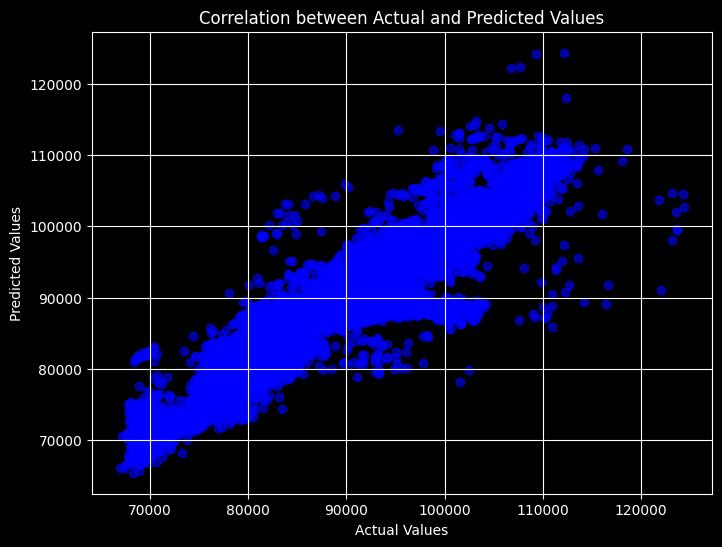

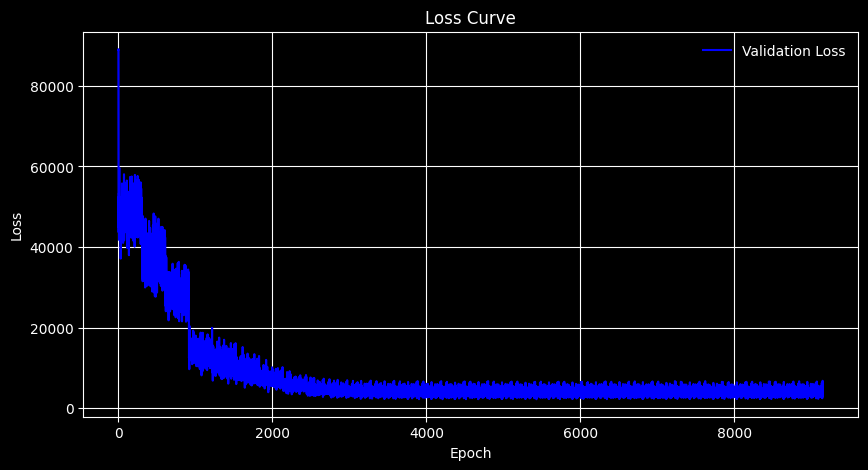

[{}]

In [26]:
trainer.test(model, val_dataloader)

### Final Evaluation on test data

Testing: |          | 0/? [00:00<?, ?it/s]

Average Test Loss: 3937.438553112588


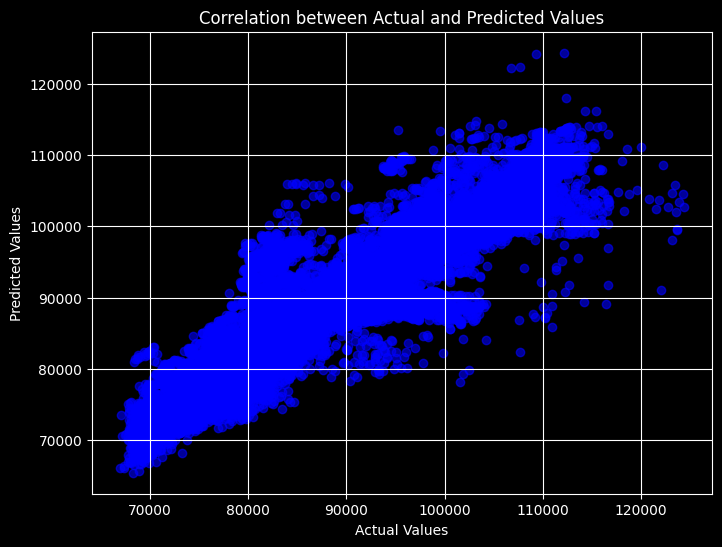

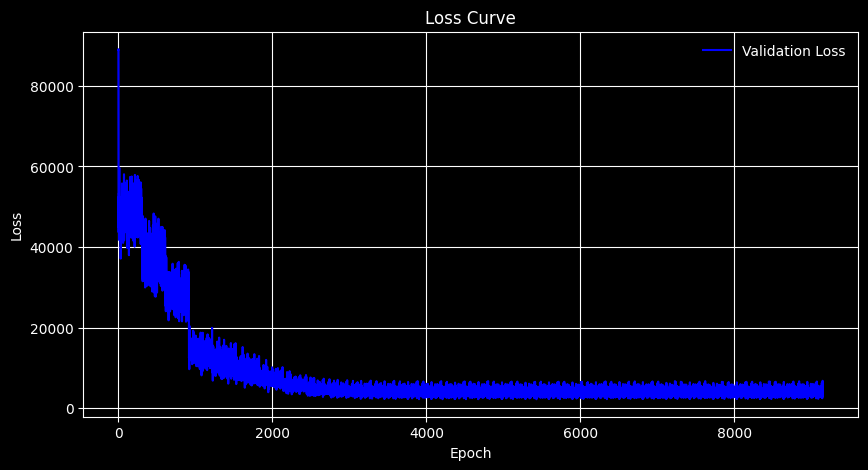

[{}]

In [27]:
trainer.test(model=model, dataloaders=test_dataloader)